# Exercise 2

In this exercise, we will use PyTorch to build a U-Net to segment tumors in brain images.

We have discussed brain tumors segmentation in lecture 2. You can review from the slides of lecture 2 (slides 66-72). For more general image segmentation, you can check this [link](https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923) for a quick tutorial.

Please use this [link](https://drive.google.com/file/d/1xtmBoayrtbhmtOp1gfkcxgCSNzXMPpmu/view?usp=sharing) to download the dataset we use for this exercise session. After downloading, you should unzip it and then put the folder *dataset* to the same path as *Exercise_2.ipynb*. This dataset contains 3064 T1-weighted contrast-enhanced images with brain tumor. For a detailed information about the dataset please refer to this [site](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

There are four important files for this exercise:
- dataset.py: We create dataset from our own data here.
- model.py: We build the model U-Net using PyTorch here.
- training.py: We define the training loop, test loop, and predict phase here.
- utils.py: We define some other functions here.

In this exercise, we will:
- Create our dataset in **dataset.py**.
- Build the model in **model.py**.
- Complete the training loop in **training.py**.

The goal is to help you become more familiar with the following:
- How to create your dataset by inheriting the *Dataset* class from pytorch.
- How to build a network using *torch.nn*.
- How to create an optimizer using *torch.optim*.

Reference:

- https://github.com/sdsubhajitdas/Brain-Tumor-Segmentation
- https://www.analyticsvidhya.com/blog/2022/10/image-segmentation-with-u-net/

## 0. Initialization

We import the package and define the device here. Change the DATASET_PATH to the path to your data.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
%matplotlib inline

import dataset
import model
import training
import utils

device = torch.device('mps' if torch.has_mps else 'cpu')

# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'png_dataset'
# Full Dataset path
DATASET_PATH = os.path.join('dataset', DATASET_USED)
# Training Epochs
EPOCHS = 20
# Filters used in UNet Model
filter_num = [16,32,64,128,256]

MODEL_NAME = f"UNet-{filter_num}.pt"

## 1. Dataset and Dataloader

Let's build a dataset from our own data! Here, you can try how to create your dataset by inheriting the *Dataset* class from pytorch.

Please open **dataset.py** to check what to implement. The three ToDo are ordered as ToDo 1, ToDo 2, ... Please check them and make sure you do not miss anything.

In [3]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

# dataset size should be 3064
assert len(tumor_dataset) == 3064, f"Dataset size should be 3064, but is {len(tumor_dataset)}"

# same index should have different images and masks because of random transformations
assert not torch.equal(tumor_dataset[0]["image"], tumor_dataset[0]["image"]), "Same index shouldn't be the same object"
assert not torch.equal(tumor_dataset[0]["mask"], tumor_dataset[0]["mask"]), "Same index shouldn't be the same object"

train_indices, test_indices = utils.get_indices(len(tumor_dataset), DATASET_USED, TEST_SPLIT)
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

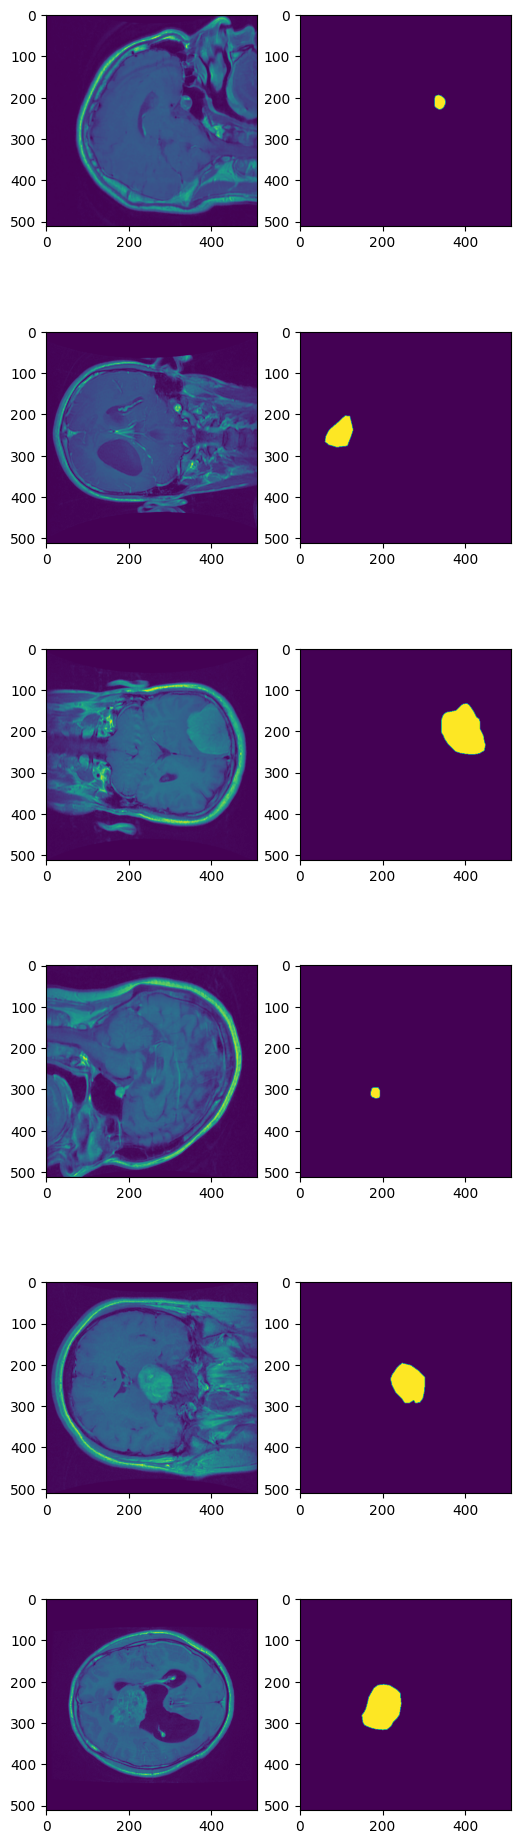

In [4]:
# get examples samples
from matplotlib import pyplot as plt

batch = next(iter(trainloader))
indices, images, masks = list(zip(*batch.items()))[1]

nrows, ncols = len(indices), 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 4*len(indices)))
for i in range(nrows):
    axs[i, 0].imshow(images[i].squeeze())
    axs[i, 1].imshow(masks[i].squeeze())

## 2. Model

U-Net is a network structure always used in biomedical image segmentation. In this section, you will try to build an U-Net with torch.nn.

Here, we explain the structure of the U-Net. An example structure is shown in the following figure. (We use this figure only to show a general structure, and the details can be changed flexibly. For example, the number of blocks, the number of convolution layers in each block, and the size of each convolution layer.)

<img src="u-net-architecture.png" width="800" height="550">

There are three parts in the U-net: 
- **Encoder**: Each encoder block contains two convolutional layers and one max-pooling layer. (In the Figure, two *conv 3x3, ReLU* and one *max pool 2x2*.)
- **Bottleneck**: There is only one bottleneck block, containing two convolutional layers. (In the Figure, two *conv 3x3, ReLU*.)
- **Decoder**: The decoder is more complicated. Each decoder block takes the output of the previous decoder block as a part of the input. Importantly, it also takes the output of a corresponding encoder block as a part of the input (the *copy and crop* part in the figure), which is named a skip connection. Each decoder block contains an upsample convolution layer, a skip connection part, and two convolutional layers. (In the Figure, one *up-conv 2x2*, one *copy and crop*, and two *conv 3x3, ReLU*)

You can check this [link](https://www.analyticsvidhya.com/blog/2022/10/image-segmentation-with-u-net/) for more details.

Let's build a U-Net using PyTorch in file **model.py**. We provide pseudo code in model.py. Again, the eight ToDo are ordered as ToDo 1, ToDo 2, ... Please check them and make sure you do not miss anything.

In [5]:
unet_model = model.UNet(filter_num).to(device)

## 3. Model Training and Testing

### 3.1. Training

To train the model, we need to define the training loop. We need to complete the 'train' and 'train_step' function in file **training.py**. Again, the seven ToDo are ordered as ToDo 1, ToDo 2, ... Please check them and make sure you do not miss anything.

In [6]:
# Training
print(device)
unet_trainer = training.Trainer(unet_model,device)

loss_record = unet_trainer.train(EPOCHS,trainloader,mini_batch=100)

print(f'Training finished!')

mps
Starting Training Process
Batch: 100,	Batch Loss: 0.1868749
Batch: 200,	Batch Loss: 0.1717368
Batch: 300,	Batch Loss: 0.1676218
Batch: 400,	Batch Loss: 0.1619957
Epoch: 001,  Loss:0.1719624,  Batch: 100,	Batch Loss: 0.1553237
Batch: 200,	Batch Loss: 0.1504782
Batch: 300,	Batch Loss: 0.1527958
Batch: 400,	Batch Loss: 0.1421724
Epoch: 002,  Loss:0.1503050,  Batch: 100,	Batch Loss: 0.1427300
Batch: 200,	Batch Loss: 0.1352176
Batch: 300,	Batch Loss: 0.1325374
Batch: 400,	Batch Loss: 0.1384911
Epoch: 003,  Loss:0.1373166,  Batch: 100,	Batch Loss: 0.1276048
Batch: 200,	Batch Loss: 0.1272330
Batch: 300,	Batch Loss: 0.1230540
Batch: 400,	Batch Loss: 0.1268109
Epoch: 004,  Loss:0.1262917,  Batch: 100,	Batch Loss: 0.1191289
Batch: 200,	Batch Loss: 0.1243786
Batch: 300,	Batch Loss: 0.1139692
Batch: 400,	Batch Loss: 0.1126393
Epoch: 005,  Loss:0.1174714,  Batch: 100,	Batch Loss: 0.1299721
Batch: 200,	Batch Loss: 0.1201681
Batch: 300,	Batch Loss: 0.1095739
Batch: 400,	Batch Loss: 0.1101936
Epoc

### 3.2. Testing

We test our model here. We use Dice Score for testing. We provide the code of testing. 

To know more about Dice Score, check this link: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [7]:
# Testing process on test data.
unet_score = unet_trainer.test(testloader)

print(f'Dice Score {unet_score}')

Dice Score 0.6508537846965433


## 4. Visualize Test Dataset Predictions

Now, you can visualize the prediction of your model! 

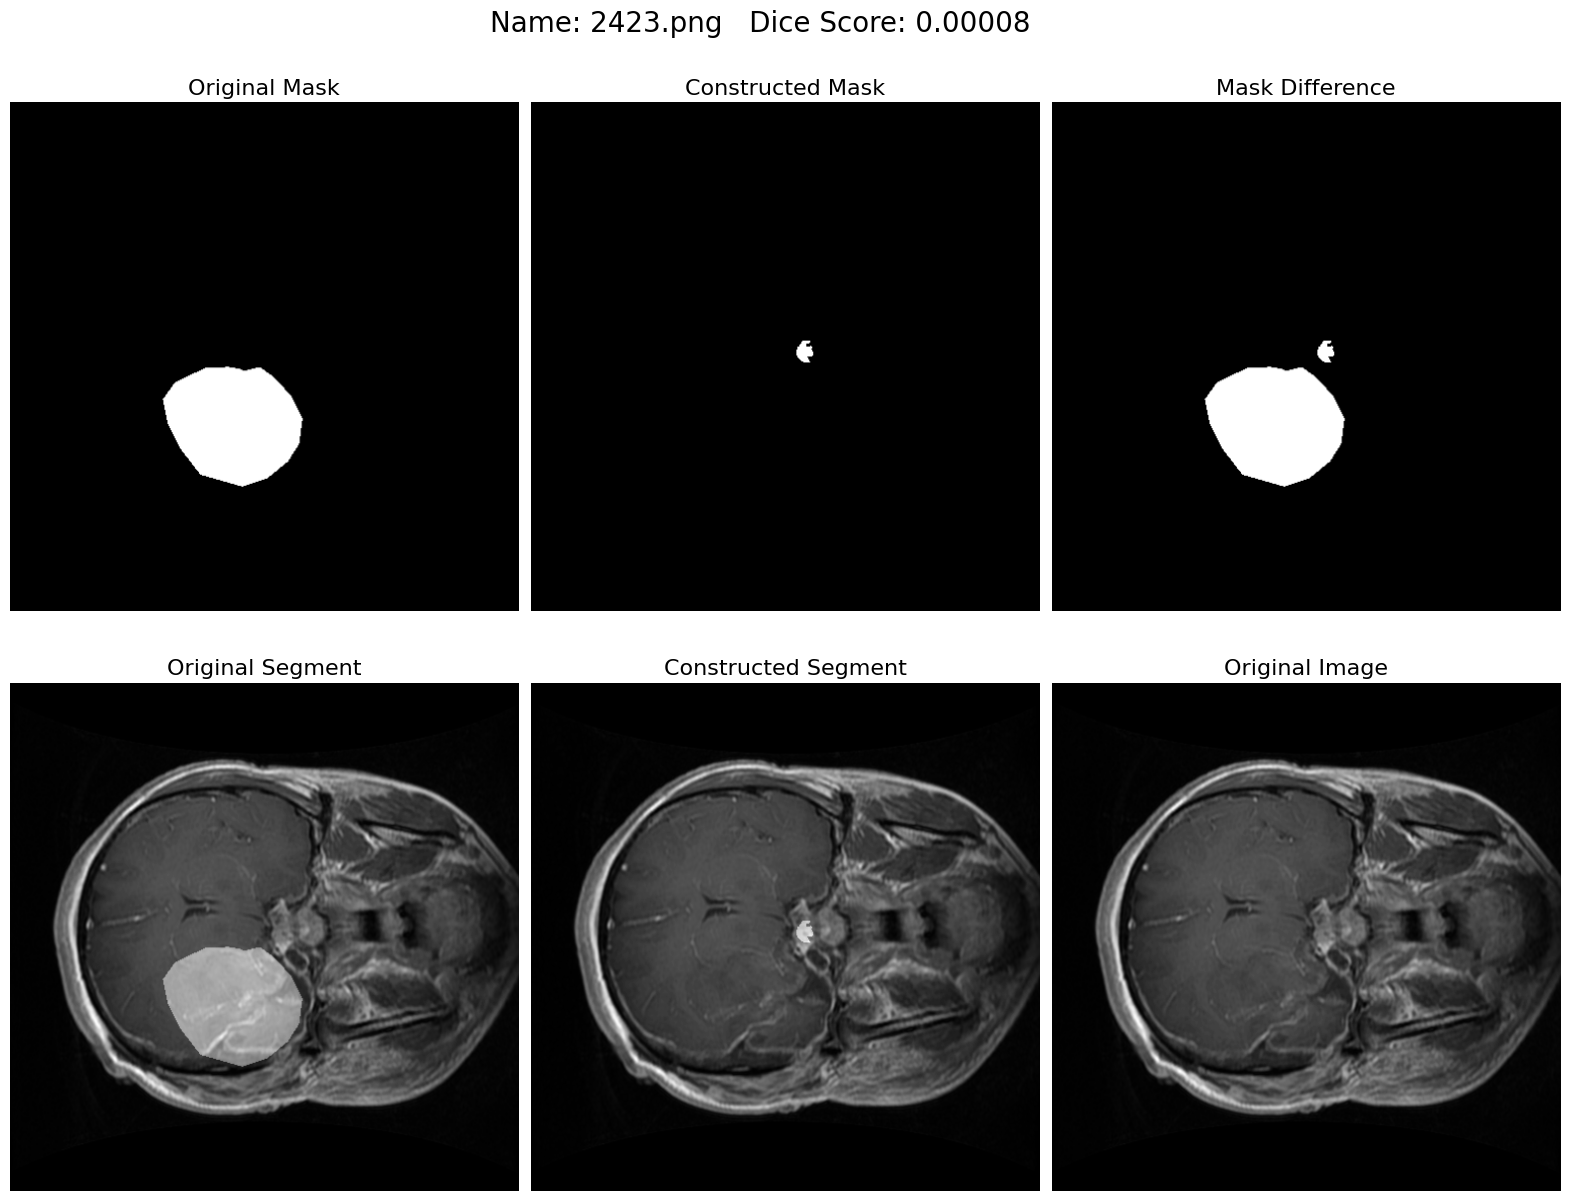

In [19]:
image_index = test_indices[0]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_trainer.predict(sample,0.65)
title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
utils.result(image,mask,output,title,save_path=None)